In [4]:
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate


filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")


mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
N, M = X.shape











In [5]:
# Explore what is X and y
print("X")
print(X)
print("y")
print(y)

# print the type of the elements of X
print("Type of X")
print(type(X[0][0]))




X
[[ 42.9  26.   31.5  17.7  28.   13.1  10.4  18.8  14.1 106.2  89.5  71.5
   74.5  93.5  51.5  32.5  26.   34.5  36.5  23.5  16.5  21.  174. ]
 [ 43.7  28.5  33.5  16.9  30.8  14.   11.8  20.6  15.1 110.5  97.   79.
   86.5  94.8  51.5  34.4  28.   36.5  37.5  24.5  17.   23.  175.3]
 [ 40.1  28.2  33.3  20.9  31.7  13.9  10.9  19.7  14.1 115.1  97.5  83.2
   82.9  95.   57.3  33.4  28.8  37.   37.3  21.9  16.9  28.  193.5]
 [ 44.3  29.9  34.   18.4  28.2  13.9  11.2  20.9  15.  104.5  97.   77.8
   78.8  94.   53.   31.   26.2  37.   34.8  23.   16.6  23.  186.5]
 [ 42.5  29.9  34.   21.5  29.4  15.2  11.6  20.7  14.9 107.5  97.5  80.
   82.5  98.5  55.4  32.   28.4  37.7  38.6  24.4  18.   22.  187.2]
 [ 43.3  27.   31.5  19.6  31.3  14.   11.5  18.8  13.9 119.8  99.9  82.5
   80.1  95.3  57.5  33.   28.   36.6  36.1  23.5  16.9  20.6 181.5]
 [ 43.5  30.   34.   21.9  31.7  16.1  12.5  20.8  15.6 123.5 106.9  82.
   84.  101.   60.9  42.4  32.3  40.1  40.3  23.6  18.8  25.5 184. ]


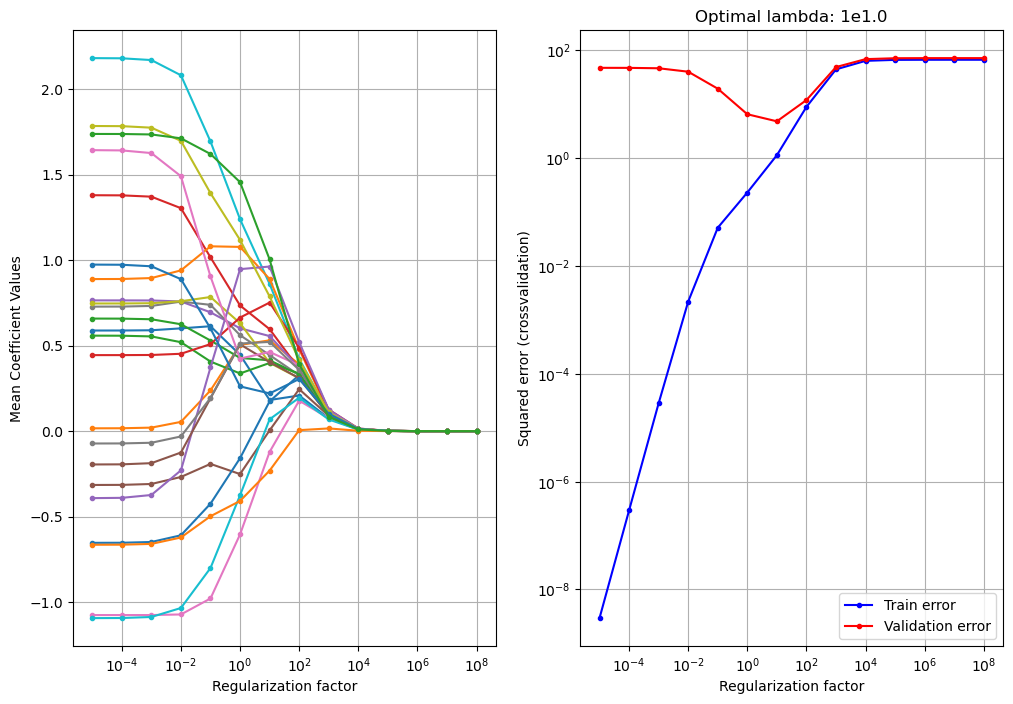

Linear regression without feature selection:
- Training error: 4.331902391461811e-25
- Test error:     513.227619042291
- R^2 train:     1.0
- R^2 test:     -6.712547528981223

Regularized linear regression:
- Training error: 1.0170327250942757
- Test error:     10.107823479744246
- R^2 train:     0.9854340172292567
- R^2 test:     0.8481042989316286

Weights in last fold:
         Offset           76.33
     biacromial            0.19
 pelvic.breadth            0.53
 bitrochanteric            0.42
    chest.depth            0.59
     chest.diam            0.57
     elbow.diam           -0.03
     wrist.diam           -0.16
      knee.diam            0.46
     ankle.diam            0.41
 shoulder.girth            0.91
    chest.girth            0.14
    waist.girth            0.93
    navel.girth             0.4
      hip.girth            0.76
    thigh.girth            0.99
    bicep.girth            0.42
  forearm.girth            0.46
     knee.girth            0.53
     calf.girth 

In [3]:

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")
